# Airbnb Data Report

#### Import the packages that will be used for this analysis

In [1]:
#import packages

#manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Processing and scoring
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

#Models to test
from sklearn import tree
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn import svm
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
from xgboost import plot_importance


plt.style.use(style='ggplot')
plt.rcParams['figure.figsize'] = (16,8)

In [2]:
#set pandas options
pd.set_option('display.max_rows', 40)
pd.options.display.float_format = '{:.2f}'.format

## Exploratory Data Analysis and Data Cleaning

### Data Cleaning Steps

In [3]:
#Read in raw data file
df = pd.read_csv('listings_nyc_9_7_22.csv', low_memory=False)

In [4]:
#Size of file
print('Number of Rows: ' + str(df.shape[0]))
print('Number of Columns: ' + str(df.shape[1]))

Number of Rows: 39881
Number of Columns: 75


In [5]:
#Get list of columns in file
print(list(df.columns))

['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name', 'description', 'neighborhood_overview', 'picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_updated', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availabil

In [6]:
#Get datatypes of each column to understand if they are correct
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39881 entries, 0 to 39880
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            39881 non-null  float64
 1   listing_url                                   39881 non-null  object 
 2   scrape_id                                     39881 non-null  float64
 3   last_scraped                                  39881 non-null  object 
 4   source                                        39881 non-null  object 
 5   name                                          39868 non-null  object 
 6   description                                   39036 non-null  object 
 7   neighborhood_overview                         23466 non-null  object 
 8   picture_url                                   39881 non-null  object 
 9   host_id                                       39881 non-null 

The price column was read in as an object. We need it to be a float for our analysis

In [7]:
#Print some values of the numerical columns
print(df['price'].head())
print('----------------')
print(df['host_response_rate'].head())
print('----------------')
print(df['host_acceptance_rate'].head())

0    $299.00 
1    $175.00 
2     $60.00 
3    $425.00 
4    $275.00 
Name: price, dtype: object
----------------
0    100%
1     75%
2    100%
3    100%
4     NaN
Name: host_response_rate, dtype: object
----------------
0     90%
1     23%
2    100%
3     19%
4     33%
Name: host_acceptance_rate, dtype: object


The price column was read in as an object because of the '$' dollar sign, and commas

In [8]:
#Remove dollar signs, spaces, and commas so we can have a float column for price
df['price'] = (df['price'].str.replace('$', '')
               .str.replace(' ', '')
               .str.replace(',', '')
               .astype(float))

#Convert rates to floats
df['host_response_rate'] = df['host_response_rate'].str.rstrip('%').astype('float')/100.0
df['host_acceptance_rate'] = df['host_acceptance_rate'].str.rstrip('%').astype('float')/100.0

C:\Users\zackt\AppData\Local\Temp/ipykernel_20824/1627767047.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['price'] = (df['price'].str.replace('$', '')


In [9]:
df.price.describe()

count   39881.00
mean      197.55
std       353.33
min         0.00
25%        80.00
50%       130.00
75%       219.00
max     16500.00
Name: price, dtype: float64

In [10]:
#Check for null values in price column
df.price.isna().sum()

0

In [11]:
#Select columns that may be relevant to our analytics question
#Removed columns that would not be relevant to modeling, like ID columns
#May revisit 'amenities' during modeling
df = (df[['host_response_rate', 'host_acceptance_rate', 
          'host_is_superhost', 'host_listings_count', 'host_total_listings_count',  
          'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 
          'latitude', 'longitude', 'room_type', 'accommodates', 
          'bathrooms',  'bedrooms', 'beds', 'price', 
          'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 
          'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 
          'maximum_nights_avg_ntm', 'calendar_updated', 'has_availability', 'availability_30', 
          'availability_60', 'availability_90', 'availability_365',  
          'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d',  'review_scores_rating', 
          'review_scores_accuracy', 'review_scores_cleanliness', 
          'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 
          'review_scores_value', 'instant_bookable', 'calculated_host_listings_count', 
          'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 
          'calculated_host_listings_count_shared_rooms', 'reviews_per_month']])

In [12]:
#Remove rows where price equals zero
#Only had to remove 30 rows
df = df[df['price'] != 0]
print(df.shape)

(39851, 45)


In [13]:
#Prices are spread throughout the neighborhood groups, we need to use the neighborhood as a more granular indicator of price
pd.pivot_table(df,index=['neighbourhood_group_cleansed','neighbourhood_cleansed'], values='price', aggfunc=np.mean)

price
neighbourhood_group_cleansed neighbourhood_cleansed       
Bronx                        Allerton               118.78
                             Baychester             111.28
                             Belmont                113.73
                             Bronx Park             123.60
                             Bronxdale               82.11
...                                                    ...
Staten Island                Tottenville            286.00
                             West Brighton           76.19
                             Westerleigh            104.00
                             Willowbrook            329.00
                             Woodrow                115.00

[244 rows x 1 columns]

In [14]:
#drop neighbourhood group
#df = df.drop('neighbourhood_group_cleansed', axis=1)

In [15]:
df['neighbourhood_group_cleansed'].value_counts()

Manhattan        16823
Brooklyn         14841
Queens            6174
Bronx             1567
Staten Island      446
Name: neighbourhood_group_cleansed, dtype: int64

In [16]:
#Since there is a different average price per neighborhood, this may be a key indicator of rental value
#The distribution of rental properties among neighborhoods is not uniform
a = pd.pivot_table(df,index=['neighbourhood_cleansed'], values='price', aggfunc=np.mean).sort_values('price', ascending=False)
b = pd.DataFrame(df['neighbourhood_cleansed'].value_counts()).rename(columns={'neighbourhood_cleansed':'count'})
df_pivot_table = pd.concat((a,b), axis=1).reset_index()

#Average prices by neighbourhood and count of rental properties
df_pivot_table.sort_values(ascending=False, by='count')

,index,price,count
112,Bedford-Stuyvesant,140.90,2778
71,Williamsburg,183.44,2453
89,Harlem,164.74,1878
8,Midtown,383.28,1694
170,Bushwick,114.35,1657
...,...,...,...
14,Willowbrook,329.00,1
166,Woodrow,115.00,1
3,Hollis Hills,497.00,1
242,Bull's Head,60.00,1


In [17]:
#Check for nulls in dataset
df.isnull().sum()

host_response_rate                              13537
host_acceptance_rate                            11852
host_is_superhost                                   0
host_listings_count                                50
host_total_listings_count                          50
                                                ...  
calculated_host_listings_count                      0
calculated_host_listings_count_entire_homes         0
calculated_host_listings_count_private_rooms        0
calculated_host_listings_count_shared_rooms         0
reviews_per_month                                8349
Length: 45, dtype: int64

In [18]:
#Fill null values with zero
df = df.fillna(0)

In [19]:
df['neighbourhood_cleansed'].nunique()

244

In [130]:
df.to_csv('airbnb_cleaned.csv', index=False)

### Exploratory Data Analysis

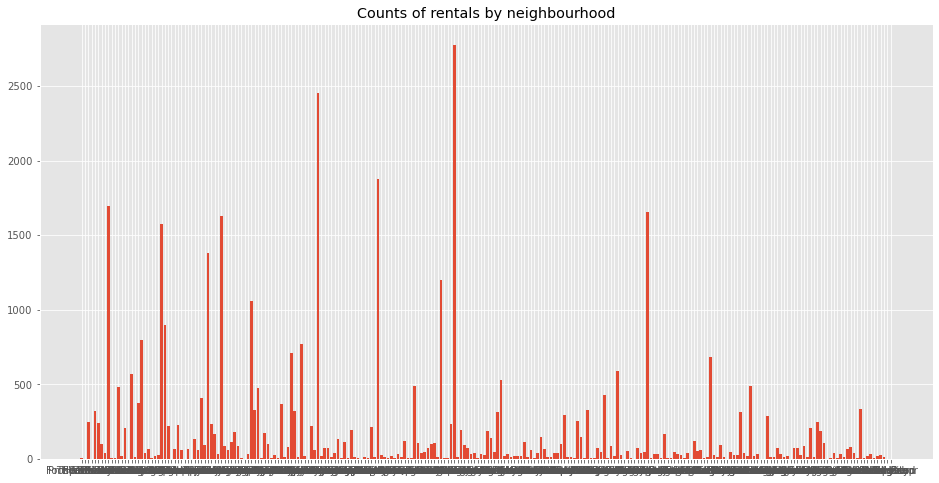

In [131]:
#counts of rentals are heavily skewed
#This could impact predicting price by neighbourhood group
plt.figure(figsize=(16,8))
plt.bar(x=df_pivot_table['index'], height=df_pivot_table['count'])
plt.title('Counts of rentals by neighbourhood')
plt.show()

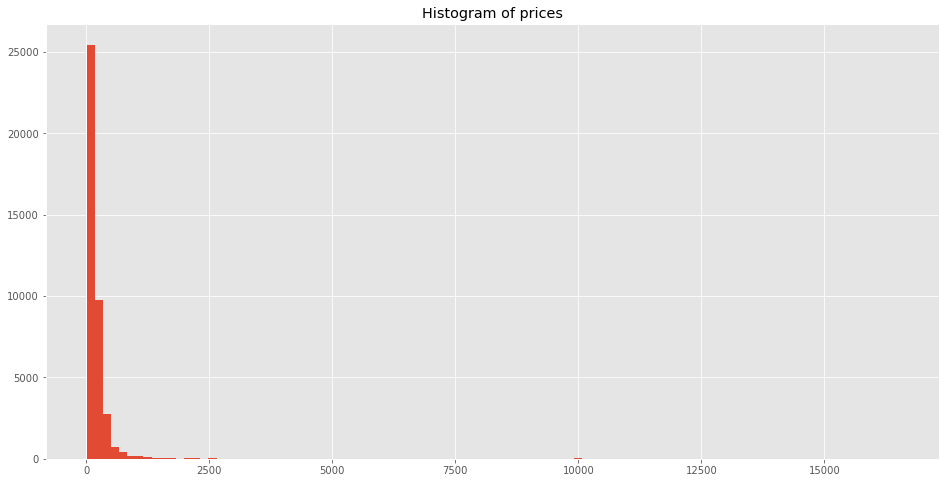

In [132]:
#Histogram of price
plt.figure(figsize=(16,8))
plt.hist(df.price, bins=100)
plt.title('Histogram of prices')
plt.show()

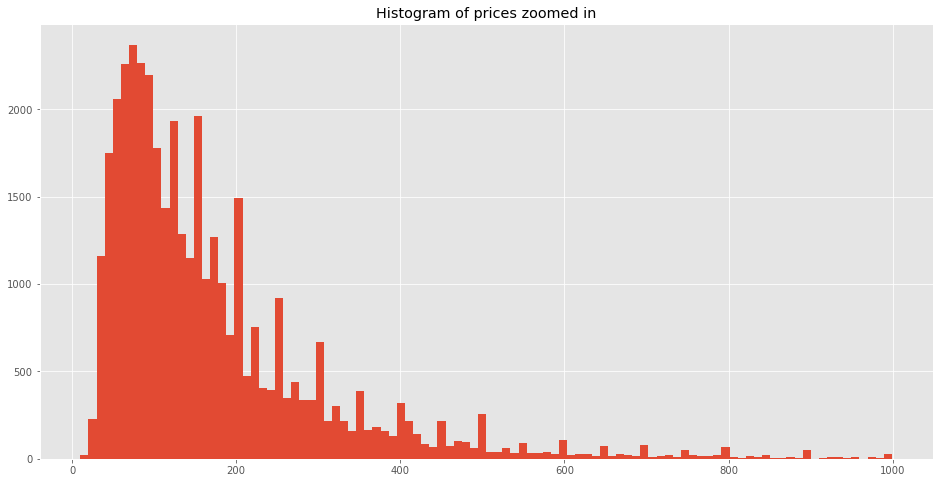

In [133]:
#Histogram of price zoomed into lower range
plt.figure(figsize=(16,8))
plt.hist(df['price'][df['price']<1000], bins=100)
plt.title('Histogram of prices zoomed in')
plt.show()

As seen above, most of the rental prices fall under $200 per night

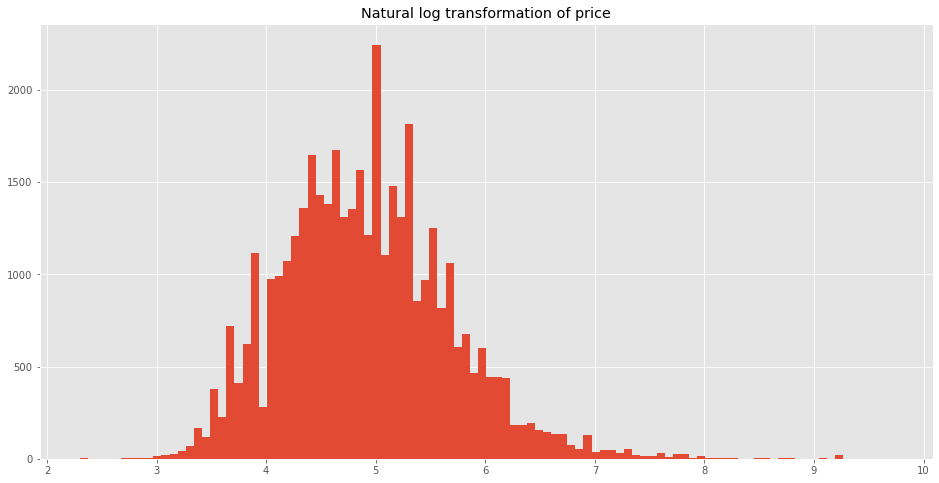

In [134]:
#Take the natural log of price to get a more normal distribution. This will be used later in modeling.
plt.figure(figsize=(16,8))
plt.hist(np.log(df.price), bins=100)
plt.title('Natural log transformation of price')
plt.show()

In [29]:
#Check if any numerical variables are correlated with price
corr_matrix = df.corr()
pd.DataFrame(corr_matrix['price'].sort_values(ascending=False).head(20))

,price
price,1.00
accommodates,0.32
bedrooms,0.28
beds,0.25
availability_30,0.16
availability_60,0.14
availability_90,0.13
host_total_listings_count,0.12
host_listings_count,0.10
availability_365,0.10


Accomodates, beds, bedrooms, and availabilty appear to have impact on price

In [136]:
#Summary statistics of price column
df['price'].describe()

count   39851.00
mean      197.70
std       353.42
min        10.00
25%        80.00
50%       130.00
75%       219.00
max     16500.00
Name: price, dtype: float64

The upper 75% mark is 219 dollars, while the max is 16500 dollars. This leads us to believe that higher prices may be outliers. These outliers would heavily impact any model we try to build

In [137]:
print('Number of rows where price is greater than $220: ' + str(df[df.price>220].shape[0]))
print('Number of rows where price is greater than $1000: ' + str(df[df.price>1000].shape[0]))

Number of rows where price is greater than $220: 9701
Number of rows where price is greater than $1000: 472


In [138]:
#After investigating the high priced Airbnb rentals, it was determined that anything over $1000
#was either an erroneous listing, or a highly unique rental. We drop these here because they greatly
#impact the models. This filters out 472 properties from the dataset, about 1%
df = pd.read_csv('airbnb_cleaned.csv')
df = df[df['price']<=1000]
df.to_csv('airbnb_less_1000.csv', index=False)
df.shape

(39379, 44)

## Modeling

### Preprocessing

In [139]:
df = pd.read_csv('airbnb_less_1000.csv')
df.shape

(39379, 44)

First we have to convert categorical variables to dummy variables. We do this by making a column transformer with the OneHotEncoder found in sklearn

In [147]:
df.select_dtypes(include='object').head()

,host_is_superhost,neighbourhood_cleansed,room_type,has_availability,instant_bookable
0,f,Kensington,Private room,t,f
1,f,Midtown,Entire home/apt,t,f
2,t,Bedford-Stuyvesant,Private room,t,f
3,f,Ridgewood,Entire home/apt,t,f
4,f,Sunset Park,Entire home/apt,t,f


In [140]:
#Make transformer
transformer = make_column_transformer(
                (OneHotEncoder(sparse=False), ['host_is_superhost', 'neighbourhood_cleansed', 'room_type', 'has_availability', 'instant_bookable']),
                 remainder = 'passthrough')

In [143]:
#separate predictors from target
y = df['price']

#Make column transformer for categorical variables
transformed = transformer.fit_transform(df.drop('price', axis=1))
X = pd.DataFrame(transformed, columns = transformer.get_feature_names())

#split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)

#size of training set
X_train.shape

(27565, 292)

We will train the models with 27,000 rows of data and 292 columns after one hot encoding

### Preliminary model analysis
We will first use cross validation on 8 models to get an early indicator of performance. This will help down select our model choices going forward.

#### Models chosen for this step
* Random Forest
* Random Forest with some tuning parameters
* KNN
* Gradient Boost
* Decision Tree
* Linear Regression
* Ada boost
* XGBoost

To compare model performance at this step, we use Root Mean Squared Error

In [148]:
#This takes a good amount of time to run
models = []

rf1 = RandomForestRegressor(max_depth=10, random_state=123, n_jobs = -1)
rf2 = RandomForestRegressor(n_estimators=200, max_depth=15, random_state=123, n_jobs=-1)
models.append(('rf1', rf1))
models.append(('rf2', rf2))
models.append(('KNN', KNeighborsRegressor()))
models.append(('Gboost', GradientBoostingRegressor()))
models.append(('Decision Tree', tree.DecisionTreeRegressor()))
models.append(('Linear Reg', linear_model.LinearRegression()))
models.append(('Ada Boost', AdaBoostRegressor()))
models.append(('XGBoost', xgb.XGBRegressor()))

results = []
names = []
scoring = 'neg_root_mean_squared_error'
for name, model in models:
    result = cross_val_score(model, X_train, y_train, cv = 5, scoring = scoring)
    names.append(name)
    results.append(result)


for i in range(len(names)):
    print(names[i], results[i].mean())

rf1 -90.3623840806476
rf2 -87.06124947390322
KNN -126.54326809492554
Gboost -91.46671334171955
Decision Tree -124.22802053700839
Linear Reg -1471.051822254185
Ada Boost -140.21617481106674
XGBoost -85.41257824318924


We can see that the XGBoost model performed the best out of the tested models

We did test multiple versions of Random Forest outside of this notebook, but there were overfitting issues and the best RMSE on the training set was around 86. We also tried to fit a neural network model, but the results were worse than the Random Forest. We decided to keep those tests out of this file for cleanliness.

The rest of this notebook will be fitting the XGBoost model. We also note that a Gradient Boost model was fitted and tuned. This model performed very similarly to the XGBoost model, but the training time was considerably longer. For that reason, we only consider XGBoost for the remainder of this analysis.

#### Fit the model without tuning to determine variable importance

In [150]:
#Create initial model on dataset
xgb_model = xgb.XGBRegressor(random_state=123)
xgb_model.fit(X_train, y_train)
train_pred = xgb_model.predict(X_train)

mse = metrics.mean_squared_error(y_train, train_pred)
rmse = mse**.5
r2 = metrics.r2_score(y_train, train_pred)
mae = metrics.mean_absolute_error(y_train, train_pred)
mape = metrics.mean_absolute_percentage_error(y_train, train_pred)


train_metrics = [('mse', mse), ('rmse', rmse), ('r2', r2), ('mae', mae), ('mape', mape)]

for i, j in train_metrics:
    print(i, j)

mse 3499.914845406186
rmse 59.16007813894591
r2 0.8310598680312755
mae 36.54732832782813
mape 0.2613300230274907


Pretty good results with just a 'bare' model. RMSE was 60 dollars, Mean Absolute Error at 36 dollars. 83% of variability explained by the model.

Below we find which variables were important to the XGBoost model

In [151]:
#Understand feature importance for XGBoost model
feat_wgts_xgb_model = pd.DataFrame(xgb_model.feature_importances_, columns=['weight'], index=X_train.columns)
feat_wgts_xgb_model.sort_values('weight', ascending=False, inplace=True)
feat_wgts_xgb_model.sort_values(by='weight', ascending=False).head(10)

,weight
onehotencoder__x2_Private room,0.31
accommodates,0.05
onehotencoder__x2_Entire home/apt,0.04
onehotencoder__x2_Hotel room,0.02
bedrooms,0.02
host_listings_count,0.02
host_total_listings_count,0.02
minimum_nights_avg_ntm,0.02
availability_30,0.02
longitude,0.02


The Private Room 'room_type' was the single most significant variable in this model

In [40]:
#Looking at the least important variables
feat_wgts_xgb_model[feat_wgts_xgb_model['weight'] < 0.01].sort_values(by='weight').head(10)

,weight
onehotencoder__x1_Port Morris,0.0
onehotencoder__x1_Arden Heights,0.0
onehotencoder__x1_Allerton,0.0
onehotencoder__x1_Bergen Beach,0.0
onehotencoder__x1_Emerson Hill,0.0
onehotencoder__x1_Woodhaven,0.0
onehotencoder__x1_Borough Park,0.0
onehotencoder__x1_Woodlawn,0.0
onehotencoder__x1_Woodrow,0.0
onehotencoder__x1_Castle Hill,0.0


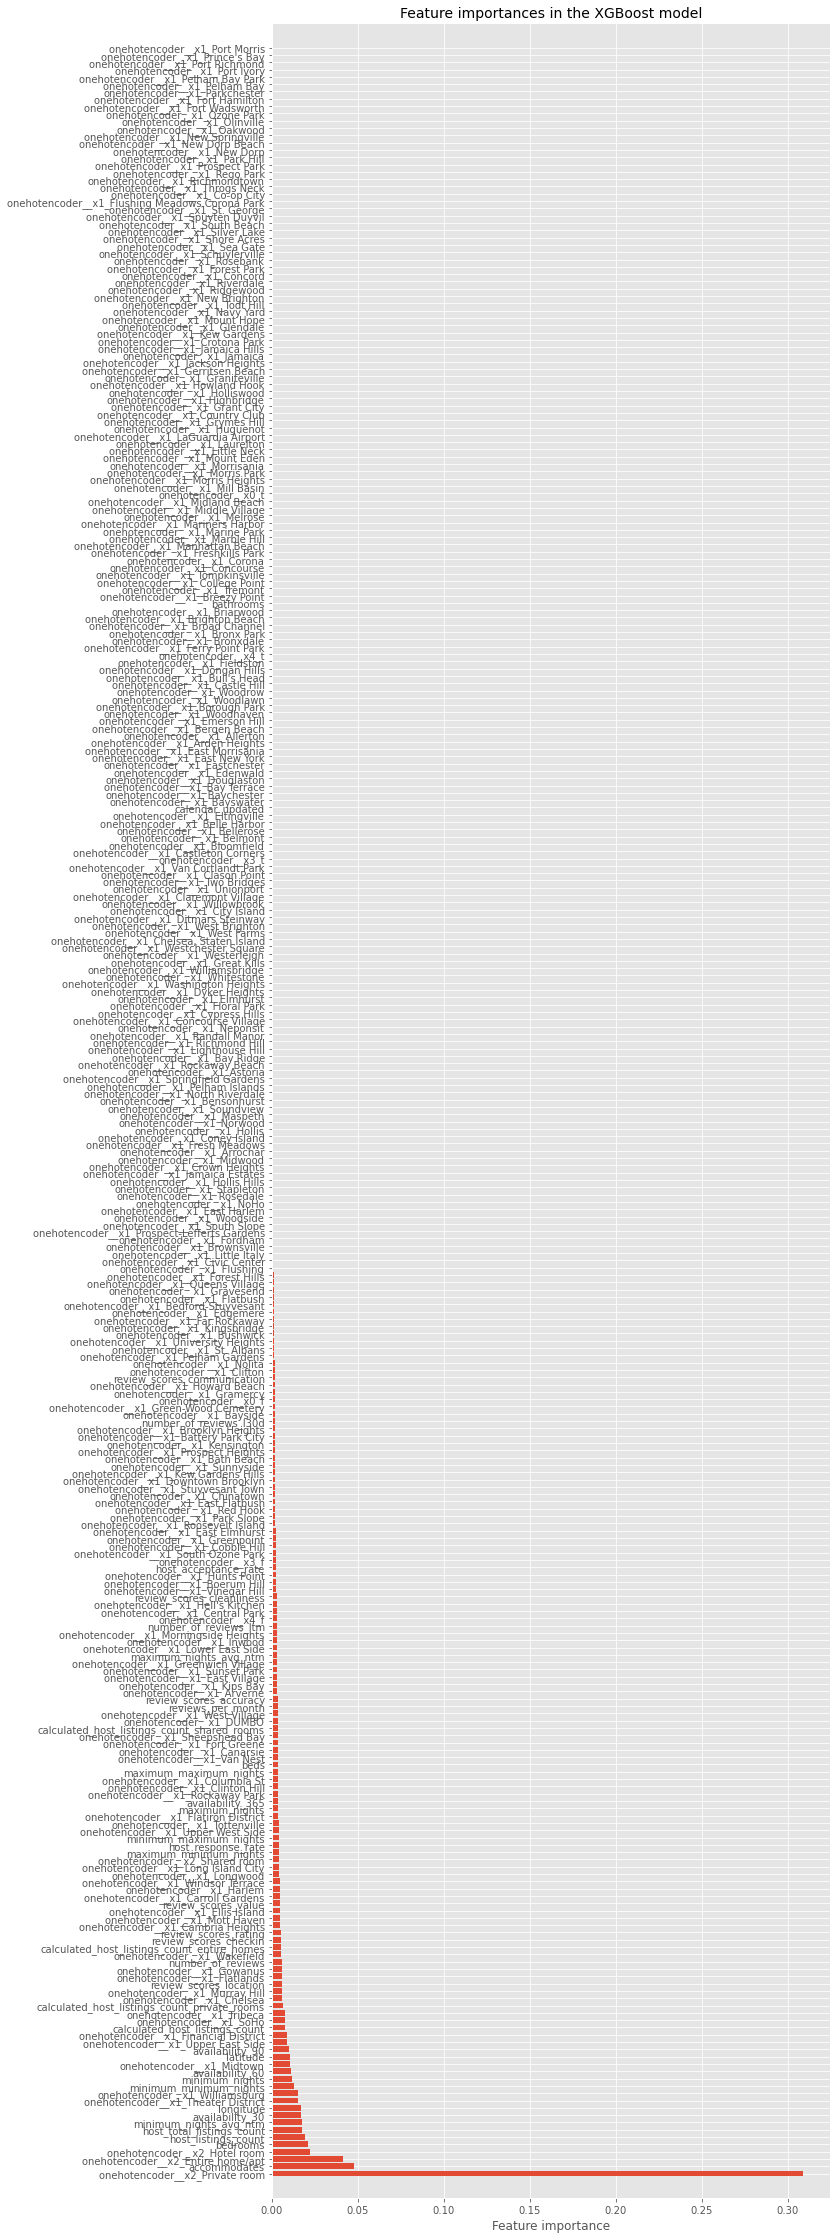

In [153]:
#Plot the feature importances
plt.figure(figsize=(10,40))
plt.barh(feat_wgts_xgb_model.index, feat_wgts_xgb_model['weight'], align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

Since the neighbourhood_cleansed column did not result in much importance, we do a little feature engineering below to keep the three most important neighbourhoods, and group the rest into an 'Other' category. This reduces the number of columns we have to feed the model by a significant factor. From 292 columns down to 44. This will help train models faster.

In [154]:
#Augment neighbourhood column
neighbourhoods = (['Theater District', 'Williamsburg', 'Midtown'])
#df.loc[df['neighbourhood_cleansed'].isin(neighbourhoods), 'neighbourhood_cleansed'] == df['neighbourhood_cleansed']
df.loc[~df['neighbourhood_cleansed'].isin(neighbourhoods), 'neighbourhood_cleansed'] = 'Other'

In [155]:
df['neighbourhood_cleansed'].value_counts()

Other               35016
Williamsburg         2438
Midtown              1627
Theater District      298
Name: neighbourhood_cleansed, dtype: int64

In [156]:
#Drop some features that were not important to the model
df2 = df.drop(['calendar_updated', 'bathrooms', 'calculated_host_listings_count', 'review_scores_location',
               'number_of_reviews', 'review_scores_checkin', 'review_scores_rating', 'review_scores_value',
               ], axis = 1)

In [157]:
#Recreate training and test sets
transformed = transformer.fit_transform(df2.drop('price', axis = 1))

X = pd.DataFrame(transformed, columns = transformer.get_feature_names())
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)
X_train.shape

(27565, 44)

Here we fit the model again using the augmented data set

In [158]:
xgb_model = xgb.XGBRegressor(random_state=123)
xgb_model.fit(X_train, y_train)
train_pred = xgb_model.predict(X_train)

mse = metrics.mean_squared_error(y_train, train_pred)
rmse = mse**.5
r2 = metrics.r2_score(y_train, train_pred)
mae = metrics.mean_absolute_error(y_train, train_pred)
mape = metrics.mean_absolute_percentage_error(y_train, train_pred)


train_metrics = [('mse', mse), ('rmse', rmse), ('r2', r2), ('mae', mae), ('mape', mape)]

for i, j in train_metrics:
    print(i, j)

mse 3467.2733675487516
rmse 58.88355770118473
r2 0.8326354651016235
mae 36.09159376003391
mape 0.2567057022326821


The model didn't lose any performance by reducing the number of columns

Below we try to fit the model using the log transform of the 'price' target variable to see if that will help reduce our error.

In [159]:
#Create XGBoost model on new training set
xgb_model = TransformedTargetRegressor(regressor=xgb.XGBRegressor(), func=np.log, inverse_func=np.exp)
xgb_model.fit(X_train, y_train)
train_pred = xgb_model.predict(X_train)

mse = metrics.mean_squared_error(y_train, train_pred)
rmse = mse**.5
r2 = metrics.r2_score(y_train, train_pred)
mae = metrics.mean_absolute_error(y_train, train_pred)
mape = metrics.mean_absolute_percentage_error(y_train, train_pred)


train_metrics = [('mse', mse), ('rmse', rmse), ('r2', r2), ('mae', mae), ('mape', mape)]

for i, j in train_metrics:
    print(i, j)

mse 4567.2652482846115
rmse 67.58154517532587
r2 0.7795390951313779
mae 35.700749030513336
mape 0.2097132371850001


Interestingly, the log transform made the model perform worse. We do not consider this going forward

Below we use sklearn's GridSearchCV to help fine tune the XGBoost model.

In [160]:
#Tune model with GridSearchCV
params = {
    'max_depth': range(5, 10, 1),
    'learning_rate': [0.1, 0.01, 0.05],
    'n_estimators': [200,300]
}

estimator = xgb.XGBRegressor(booster='gbtree')

grid_search = GridSearchCV(
    estimator = estimator,
    param_grid = params,
    scoring = 'neg_mean_squared_error',
    n_jobs = -1,
    cv = 3,
    verbose = 1,
    error_score='raise'
)

In [161]:
#Fit the model
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


GridSearchCV(cv=3, error_score='raise',
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, mon...
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, predictor=None,
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
  

In [162]:
#This shows the best parameters for our model based on the param grid we fed GridSearchCV
grid_search.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=300, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [163]:
grid_search.best_score_

-7030.313193446508

GridSearchCV is useful in finding the best parameters, but takes a long time to run because of all the combinations of parameters.

In [172]:
#Run tuned XGBoost model
#We chose a higher number of estimators based on multiple runs not shown
xgb_model = xgb.XGBRegressor(learning_rate=0.1, n_estimators=500, max_depth=7, random_state=123)
xgb_model.fit(X_train, y_train)
train_pred = xgb_model.predict(X_train)

mse = metrics.mean_squared_error(y_train, train_pred)
rmse = mse**.5
r2 = metrics.r2_score(y_train, train_pred)
mae = metrics.mean_absolute_error(y_train, train_pred)
mape = metrics.mean_absolute_percentage_error(y_train, train_pred)


train_metrics = [('mse', mse), ('rmse', rmse), ('r2', r2), ('mae', mae), ('mape', mape)]

for i, j in train_metrics:
    print(i, j)

mse 1655.7104450664656
rmse 40.69042203106851
r2 0.9200792152247174
mae 25.031233480106483
mape 0.18827158349945436


Looking good here with an RMSE of 40 and explaining 92% of the variability in the price. This was the best model we created. Overall, around 50 models were fitted on the training data using a variety of algorithms. Again, here we are just showing the best of the best

Finally, we run the model on our hold out dataset. The model has never seen this data before this step.

In [175]:
#Compare XGBoost vs GradientBoost models on test set
xgb_test_pred = xgb_model.predict(X_test)

xgb_mse = metrics.mean_squared_error(y_test, xgb_test_pred)
xgb_rmse = mse**.5
xgb_r2 = metrics.r2_score(y_test, xgb_test_pred)
xgb_mae = metrics.mean_absolute_error(y_test, xgb_test_pred)
xgb_mape = metrics.mean_absolute_percentage_error(y_test, xgb_test_pred)


xgb_test_metrics = [('mse', xgb_mse), ('rmse', xgb_rmse), ('r2', xgb_r2), ('mae', xgb_mae), ('mape', xgb_mape)]

print('XGBoost Test Results')
print('-------------------------------')
for i, j in xgb_test_metrics:
    print(i, j)

XGBoost Test Results
-------------------------------
mse 7028.577730585342
rmse 40.69042203106851
r2 0.6663916636502273
mae 47.26101385713613
mape 0.3072905058838896


The model performed pretty comparably to the training data. THe RMSE was the same, however MAE was a bit higher on the test set. Overall, the model generalizes well to unseen data and doesn't show a lot of signs of overfitting.

Below we plot the predicted price vs actual price in the test set

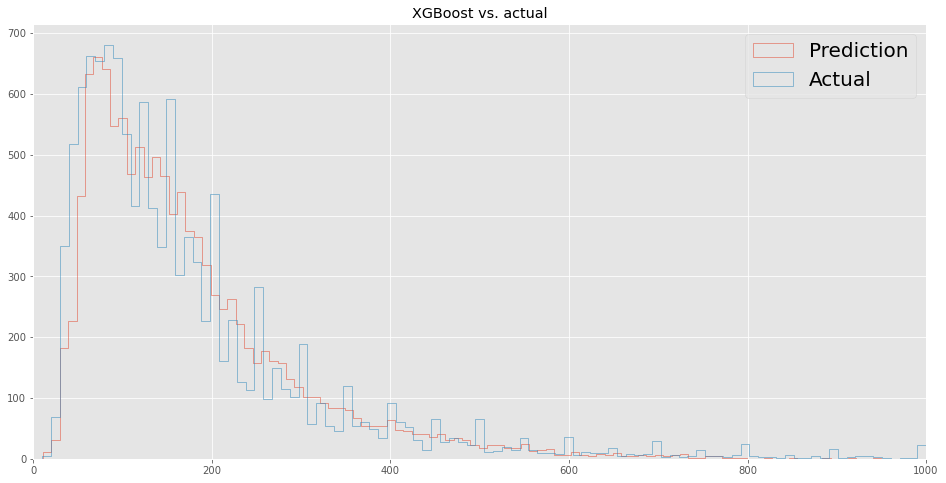

In [179]:
plt.hist(xgb_test_pred, bins=100, histtype='step', label='Prediction')
plt.hist(y_test, bins=100, histtype='step', label='Actual')
plt.legend(prop={'size': 20})
plt.xlim((0,1000))
plt.title('XGBoost vs. actual')
plt.show()

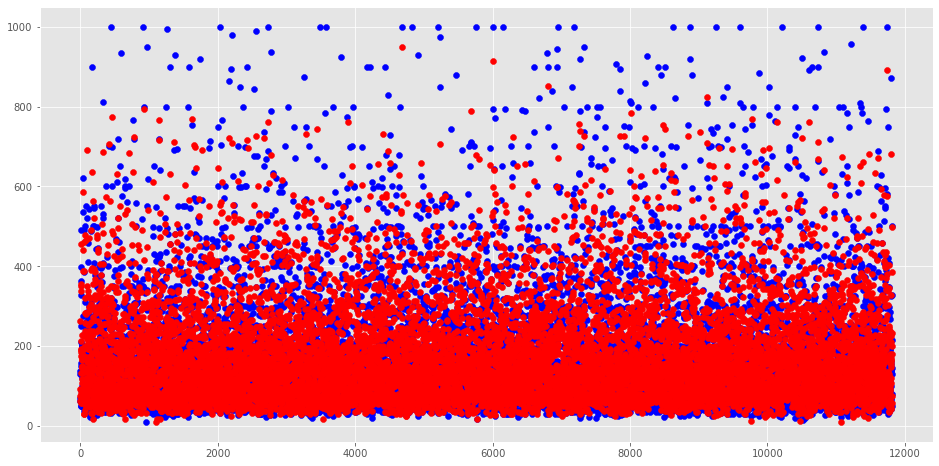

In [56]:
plt.scatter(range(len(y_test)), y_test, color='blue')
plt.scatter(range(len(xgb_test_pred)), xgb_test_pred, color='red')
plt.show()

Below we look at the feature importances again for our model

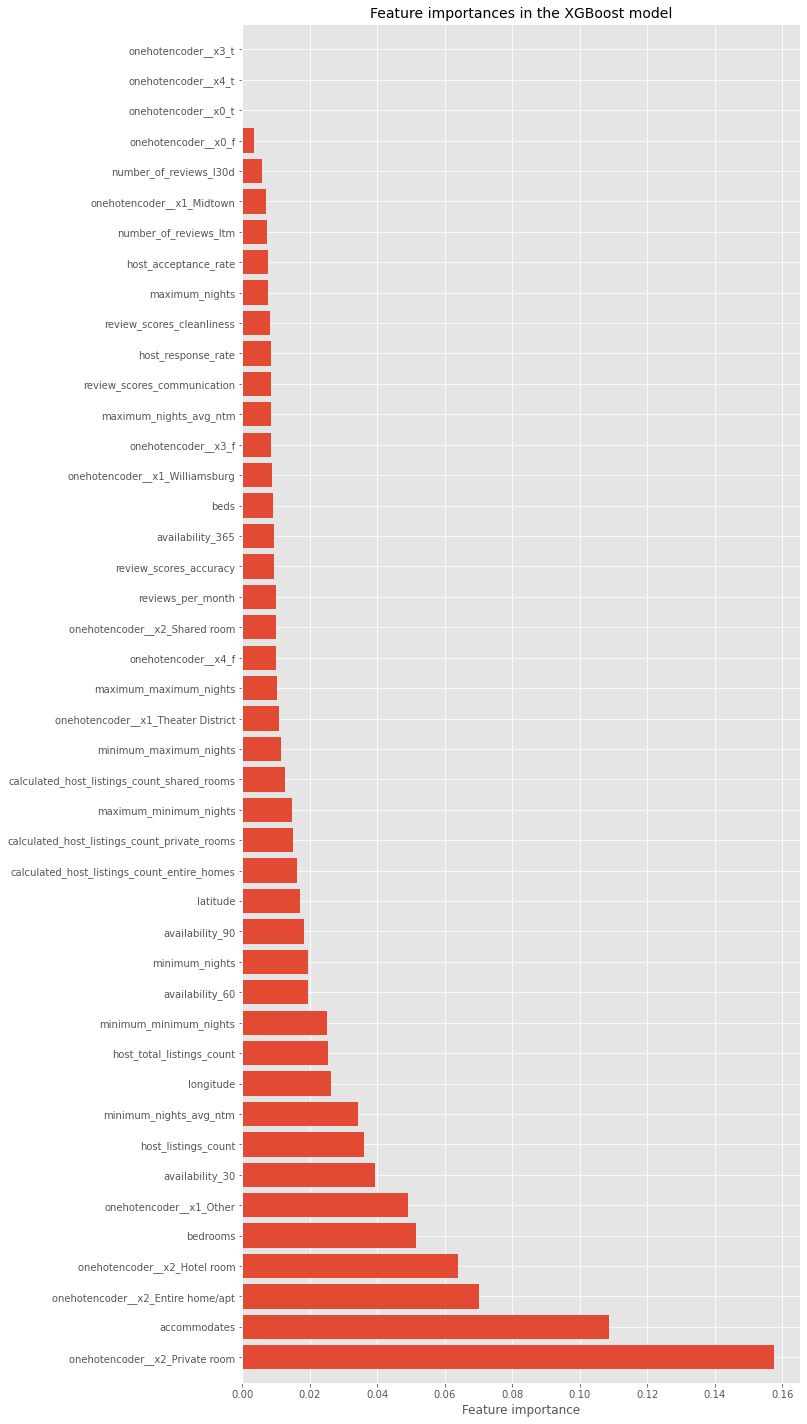

In [180]:
feat_wgts_xgb_model = pd.DataFrame(xgb_model.feature_importances_, columns=['weight'], index=X_train.columns)
feat_wgts_xgb_model.sort_values('weight', ascending=False, inplace=True)
#feat_wgts_xgb_model.sort_values(by='weight')

plt.figure(figsize=(10,25))
plt.barh(feat_wgts_xgb_model.index, feat_wgts_xgb_model['weight'], align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()